### download data set

In [0]:
from google.colab import drive
drive.mount('/content/drive')
#allaeddine.guissous@gmail.com account contain the dataset

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Extract the data
#!unzip ISIC_2019_Training_Input.zip

import zipfile
import time
start = time.time()
with zipfile.ZipFile("drive/My Drive/skin-cancer-mnist-ham10000.zip","r") as zip_ref:
    zip_ref.extractall()

end = time.time()
elapsed = end - start
print(elapsed)

In [0]:
with zipfile.ZipFile("HAM10000_images_part_1.zip","r") as zip_ref:
    zip_ref.extractall("input2/HAM10000_images_part_1")
    
with zipfile.ZipFile("HAM10000_images_part_2.zip","r") as zip_ref:
    zip_ref.extractall("input2/HAM10000_images_part_2")    

In [0]:
#!rm -r input


In [0]:
from numpy.random import seed
seed(101)
from tensorflow import set_random_seed
set_random_seed(101)

import pandas as pd
import numpy as np
#import keras
#from keras import backend as K

import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline


### color_constancy

In [0]:
# !rm -r ISIC_2019_Training_Input2
# !rm -r base_dir

In [0]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt

def gray_world(img):
    """
    Parameters
    ----------
    img: 2D numpy array
        The original image with format of (h, w, c)
    """
    img = img.astype(np.float)
    pixels_num = img.shape[0] * img.shape[1]
    bgr_avg = np.sum(np.sum(img, axis = 0), axis = 0) / pixels_num
    gray_avg = np.sum(bgr_avg) / img.shape[2]
    bgr_k = gray_avg / bgr_avg
    return img * np.transpose(bgr_k)
def white_patch_retinex(img, para):
    """
    Parameters
    ----------
    img: 2D numpy array
        The original image with format of (h, w, c)
    para: 0 or 1
        0 : original algorithm
        1 : optimization algorithm
    """
    img = img.astype(np.float)
    out = np.zeros(img.shape, dtype=float)
    L = [0, 0, 0]
    if para == 0:
        for i in range(3):
            L[i] = np.max(img[:, :, i].flatten())
            out[:, :, i] = img[:, :, i] * 255.0 / L[i]
    elif para == 1:
        n_p = 0.1 * img.shape[0] * img.shape[1]
        for i in range(3):
            H, bins = np.histogram(img[:, :, i].flatten(), 256)
            sums = 0
            for j in range(255, -1, -1):
                if sums < n_p:
                    sums += H[j]
                else:
                    L[i] = j
                    out[:, :, i] = img[:, :, i] * 255.0 / L[i]
                    break
    return out
def shade_of_gray(img, power=6, gamma=None):
    """
    Parameters
    ----------
    img: 2D numpy array
        The original image with format of (h, w, c)
    power: int
        The degree of norm, 6 is used in reference paper
    gamma: float
        The value of gamma correction, 2.2 is used in reference paper
    """
    img_dtype = img.dtype

    if gamma is not None:
        img = img.astype('uint8')
        look_up_table = np.ones((256,1), dtype='uint8') * 0
        for i in xrange(256):
            look_up_table[i][0] = 255 * pow(i/255, 1/gamma)
        img = cv2.LUT(img, look_up_table)

    img = img.astype('float32')
    img_power = np.power(img, power)
    rgb_vec = np.power(np.mean(img_power, (0,1)), 1/power)
    rgb_norm = np.sqrt(np.sum(np.power(rgb_vec, 2.0)))
    rgb_vec = rgb_vec/rgb_norm
    rgb_vec = 1/(rgb_vec*np.sqrt(3))
    img = np.multiply(img, rgb_vec)

    return img.astype(img_dtype)
def general_gray_world(img, power=2, sigma=3):
    """
    Parameters
    ----------
    img: 2D numpy array
        The original image with format of (h, w, c)
    power: int
        The degree of norm, 2 is used in reference paper
    sigma: float
        Filtering image with a Guassian low-pass filter with standard deviation sigma
    """
    blur = cv2.GaussianBlur(img, (3, 3), sigma)
    return shade_of_gray(blur, power)
  


In [0]:
import os
data_list=[]

for dirname, dirnames, filenames in os.walk('input2'):
    # print path to all subdirectories first.
    #for subdirname in dirnames:
        #print(os.path.join(dirname, subdirname))

    # print path to all filenames.
    for filename in filenames:
        path = os.path.join(dirname, filename)
        path = os.path.relpath(path, 'input2') 
        data_list.append(path)
       
        #print(os.path.join(dirname, filename))
        
    # Advanced usage:
    # editing the 'dirnames' list will stop os.walk() from recursing into there.
    if '.git' in dirnames:
        # don't go into any .git directories.
        dirnames.remove('.git')
        
       

In [0]:
os.mkdir('input')
os.mkdir('input/HAM10000_images_part_1')
os.mkdir('input/HAM10000_images_part_2')


In [0]:
import cv2 as cv
import os
#import process_bar
import sys
import time
start = time.time()
from IPython.display import clear_output
#width = 320
#width = 480

# data_d1 = os.listdir('input/HAM10000_images_part_1')
# data_d2 = os.listdir('input/HAM10000_images_part_2')
# data_dir = []
# data_d1.extend(data_d2)
 

#data_dir = '../data/ISIC2018/ISIC2018_Task3_Validation_Input/'
#for cnt in [2,5,8,9]:
#cnt = int(sys.argv[1])
#output_dir = '../data/valid_{}'.format(cnt)
#output_dir = './valid_wpr1'
output_dir = 'input'
data_dir = 'input2'
os.makedirs(output_dir, exist_ok=True)
#print('-----{}-----'.format(cnt))
cpt = 0
done = 0
#process_bar_ = process_bar.process_bar(195)
for img in data_list :
    if img.split('.')[-1] != 'jpg':
        continue
    image_path = os.path.join(data_dir, img)
    image_np = cv.imread(image_path)
    #image_np =cv2.resize(image_np,(width,width)) 
   
    #new_image_np = shade_of_gray(image_np, power=cnt)
    new_image_np = white_patch_retinex(image_np, 1)
    output_path = os.path.join(output_dir, img)
    #print(output_path)
    cv.imwrite(output_path,new_image_np)
    #process_bar_.show_process()
    cpt =  cpt + 1
    if cpt == 1000:
      done = done + 1000
      clear_output()
      print(10015-done,' remaining')
     
      cpt = 0

end = time.time()
elapsed = end - start
print(elapsed)      

### visualize color constancy


In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread(image_path)
image2 = mpimg.imread(output_path)
plt.imshow(image)
plt.show()
plt.imshow(image2)
plt.show()

In [0]:
!cp HAM10000_metadata.csv -d input

### Create the directory structure

In these folders we will store the images that will later be fed to the Keras generators. 

In [0]:
base_dir = 'base_dir'
train_dir = os.path.join(base_dir, 'train_dir')
val_dir = os.path.join(base_dir, 'val_dir')

In [0]:


# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 7 folders inside 'base_dir':


# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN, VALIDATION AND TEST FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)



# create new folders inside val_dir
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)



### Create Train and Val Sets

In [0]:
!cp HAM10000_metadata.csv -d input

In [0]:
df_data = pd.read_csv('input/HAM10000_metadata.csv')

df_data.head()

### Create a stratified val set

In [0]:
# this will tell us how many images are associated with each lesion_id
df = df_data.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

In [0]:
# here we identify lesion_id's that have duplicate images and those that have only
# one image.

def identify_duplicates(x):
    
    unique_list = list(df['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
# create a new colum that is a copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
# apply the function to this new column
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

In [0]:
df_data['duplicates'].value_counts()

In [0]:
# now we filter out images that don't have duplicates
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape

In [0]:
# now we create a val set using df because we are sure that none of these images
# have augmented duplicates in the train set
y = df['dx']

_, df_val = train_test_split(df, test_size=0.17, random_state=101, stratify=y)

df_val.shape

In [0]:
df_val['dx'].value_counts()

### Create a train set that excludes images that are in the val set

In [0]:
# This set will be df_data excluding all rows that are in the val set

# This function identifies if an image is part of the train
# or val set.
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows

# create a new colum that is a copy of the image_id column
df_data['train_or_val'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   
# filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

In [0]:
df_train['dx'].value_counts()

In [0]:
df_val['dx'].value_counts()

### Transfer the Images into the Folders

In [0]:
 #!rm -r base_dir

In [0]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [0]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('input/HAM10000_images_part_1')
folder_2 = os.listdir('input/HAM10000_images_part_2')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('input/HAM10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('input/HAM10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('input/HAM10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('input/HAM10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
        

In [0]:
!cp -r 'drive/My Drive/drive2/base_dir/val_dir/scc' -d base_dir/val_dir

In [0]:
!cp -r 'drive/My Drive/drive2/base_dir/train_dir/scc' -d base_dir/train_dir

In [0]:
!rm -r base_dir/train_dir/akiec
!rm -r base_dir/val_dir/akiec

In [0]:
!cp -r 'drive/My Drive/drive2/base_dir/val_dir/ak' -d base_dir/val_dir

In [0]:
!cp -r 'drive/My Drive/drive2/base_dir/train_dir/ak' -d base_dir/train_dir

In [0]:
# check how many train images we have in each folder
total_train = 0

nvt = len(os.listdir('base_dir/train_dir/nv'))
print(nvt)
melt = len(os.listdir('base_dir/train_dir/mel'))
print(melt)
bklt = len(os.listdir('base_dir/train_dir/bkl'))
print(bklt)
bcct = len(os.listdir('base_dir/train_dir/bcc'))
print(bcct)
akt = len(os.listdir('base_dir/train_dir/ak'))
print(akt)
vasct = len(os.listdir('base_dir/train_dir/vasc'))
print(vasct)
dft = len(os.listdir('base_dir/train_dir/df'))
print(dft)
scct = len(os.listdir('base_dir/train_dir/scc'))
print(scct)

total_train = nvt+melt+bklt+bcct+akt+vasct+dft+scct
print(total_train)

In [0]:
# check how many val images we have in each folder
total_val = 0
nv = len(os.listdir('base_dir/val_dir/nv'))
print(nv)
mel = len(os.listdir('base_dir/val_dir/mel'))
print(mel)
bkl = len(os.listdir('base_dir/val_dir/bkl'))
print(bkl)
bcc = len(os.listdir('base_dir/val_dir/bcc'))
print(bcc)
ak = len(os.listdir('base_dir/val_dir/ak'))
print(ak)
vasc = len(os.listdir('base_dir/val_dir/vasc'))
print(vasc)
df = len(os.listdir('base_dir/val_dir/df'))
print(df)
scc = len(os.listdir('base_dir/val_dir/scc'))
print(scc)

total_val=nv+mel+bkl+bcc+ak+vasc+df+scc
print(total_val)

### binary transformation

In [0]:
#Delete all images except 5 in each folder in val_dir, except MEL and NV 
import os, random
fldlist = os.listdir('base_dir/val_dir')
for fld in fldlist:
  if not (fld == 'vasc' or fld == 'df'):
      for i in range(len(os.listdir(os.path.join(val_dir,fld)))-1):
          file = random.choice(os.listdir(os.path.join(val_dir,fld)))
          dst = os.path.join(val_dir,fld, file)
          os.remove(dst)

In [0]:
total = 0
train_list = os.listdir(val_dir)
for col in train_list:
        npath = os.path.join(val_dir, col)
        print(col,len(os.listdir(npath)))
        total = total+len(os.listdir(npath))
print('total = ',total)        
val_len = total

In [0]:
#Delete all images except 5 in each folder in train_dir, except MEL and NV 
import os, random
fldlist = os.listdir('base_dir/train_dir')
for fld in fldlist:
  if not (fld == 'vasc' or fld == 'df'):
      for i in range(len(os.listdir(os.path.join(train_dir,fld)))-5):
          file = random.choice(os.listdir(os.path.join(train_dir,fld)))
          dst = os.path.join(train_dir,fld, file)
          os.remove(dst)

In [38]:
# training examples
total = 0
train_list = os.listdir(train_dir)
for col in train_list:
        npath = os.path.join(train_dir, col)
        print(col,len(os.listdir(npath)))
        total = total+len(os.listdir(npath))
print('total = ',total) 
train_len = total

nv 5
mel 5
ak 5
scc 5
bkl 5
df 109
vasc 131
bcc 5
total =  270
nv 5
mel 5
ak 5
scc 5
bkl 5
df 109
vasc 131
bcc 5
total =  270


### Copy the train images  into aug_dir

In [39]:
# note that we are not augmenting class 'nv'
#class_list = ['mel','bkl','bcc','ak','vasc','df','scc','nv']
class_list = ['vasc','df']
for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)



    # Generate the augmented images and add them to the training folders
    
    ###########
    
    num_aug_images_wanted = 7000 # total number of images we want to have in each class
    
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 131 images belonging to 1 classes.
Found 131 images belonging to 1 classes.
Found 109 images belonging to 1 classes.
Found 109 images belonging to 1 classes.


In [0]:
total = 0
train_list = os.listdir(val_dir)
for col in train_list:
        npath = os.path.join(val_dir, col)
        print(col,len(os.listdir(npath)))
        total = total+len(os.listdir(npath))
print('total = ',total)        
val_len = total

In [0]:
# training examples
total = 0
train_list = os.listdir(train_dir)
for col in train_list:
        npath = os.path.join(train_dir, col)
        print(col,len(os.listdir(npath)))
        total = total+len(os.listdir(npath))
print('total = ',total) 
train_len = total

### Visualize 50 augmented images

In [0]:
# plots images with labels within jupyter notebook
# source: https://github.com/smileservices/keras_utils/blob/master/utils.py

def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
plots(imgs, titles=None) # titles=labels will display the image labels

In [0]:
# End of Data Preparation
### ===================================================================================== ###
# Start of Model Building

### Set Up the Generators

In [0]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = total_train
num_val_samples = total_val
train_batch_size = 16
val_batch_size = 16
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)


In [45]:

datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.densenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 11310 images belonging to 8 classes.
Found 23 images belonging to 8 classes.
Found 23 images belonging to 8 classes.
Found 11310 images belonging to 8 classes.
Found 23 images belonging to 8 classes.
Found 23 images belonging to 8 classes.


### Modify MobileNet Model

In [46]:
# create a copy of a mobilenet model

mobile = tensorflow.keras.applications.densenet.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")


74842112/74836368 [==============================] - 5s 0us/step


In [0]:
mobile.summary()

In [0]:
type(mobile.layers)

In [0]:
# How many layers does MobileNet have?
len(mobile.layers)

In [0]:
#get the last layer shape
last_layer = mobile.get_layer('relu')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

In [0]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
#x = mobile.layers[-6].output
x = layers.GlobalMaxPooling2D()(last_output)
#x = layers.Dense(512)(x)
# Create a new dense layer for predictions
# 7 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(8, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

In [0]:
model.summary()

In [0]:
# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.

# for layer in model.layers[:-23]:
#     layer.trainable = False

### Train the Model

In [0]:
import tensorflow as tf
def median_weight_class_loss(y_true, y_pred):
  epsilon = tf.constant(value=1e-10)
  #weight_sample = np.array([1113,6705,514,327,1099,115,142])/10015
  weight_sample = np.array([867,514,1099,115,900,6705,628,142])/10015
 #weight_sample = np.array( ak ,bcc,bkl ,df ,mel, nv ,scc,vasc)/full
#mel = 1113 -> 900
  weight_sample = 0.05132302/weight_sample
  xent = -tf.reduce_sum(y_true * tf.log(y_pred + epsilon) * weight_sample, axis=1)
  return xent
  #['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC']
  
#327,514,1099,115,1113,6705,142
#{'ak': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


# 867   ak
# 514   bcc
# 1099  bkl
# 115   df
# 1113  mel
# 6705  nv
# 628   scc
# 142   vasc

In [0]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss= categorical_crossentropy,
#model.compile(loss= median_weight_class_loss,
              optimizer=optimizer,
              metrics=['categorical_accuracy'])



In [56]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'ak': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'scc': 6, 'vasc': 7}
{'ak': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'scc': 6, 'vasc': 7}


In [0]:
# Add weights to try to make the model more sensitive to melanoma

class_weights={
    0: 1.0, # ak
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # scc
    7: 1.0, # vasc
}

In [58]:

filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                              #class_weight=class_weights,
                              validation_data=valid_batches,
                              validation_steps=val_steps,
                              epochs=15, verbose=1,
                              callbacks=callbacks_list)


Epoch 1/15
Epoch 1/15
623/624 [============================>.] - ETA: 0s - loss: 0.1297 - categorical_accuracy: 0.9725
Epoch 00001: val_categorical_accuracy improved from -inf to 0.78261, saving model to model.h5

Epoch 00001: val_categorical_accuracy improved from -inf to 0.78261, saving model to model.h5
624/624 [==============================] - 594s 951ms/step - loss: 0.1295 - categorical_accuracy: 0.9726 - val_loss: 0.6532 - val_categorical_accuracy: 0.7826
Epoch 2/15
Epoch 2/15
623/624 [============================>.] - ETA: 0s - loss: 0.0071 - categorical_accuracy: 0.9981
Epoch 00002: val_categorical_accuracy did not improve from 0.78261
624/624 [==============================] - 281s 450ms/step - loss: 0.0071 - categorical_accuracy: 0.9981 - val_loss: 1.4341 - val_categorical_accuracy: 0.7826

Epoch 00002: val_categorical_accuracy did not improve from 0.78261
624/624 [==============================] - 281s 450ms/step - loss: 0.0071 - categorical_accuracy: 0.9981 - val_loss: 1.4

### Evaluate the model using the val set

In [0]:
# get the metric names so we can use evaulate_generator
model.metrics_names

In [60]:
# Here the the last epoch will be used.

val_loss, val_cat_acc = \
model.evaluate_generator(test_batches, 
                        steps=total_val)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)


val_loss: 1.1733009619214194
val_cat_acc: 0.7374071
val_loss: 1.1733009619214194
val_cat_acc: 0.7374071


In [61]:
# Here the best epoch will be used.

model.load_weights('model.h5')

val_loss, val_cat_acc = \
model.evaluate_generator(test_batches, 
                        steps=total_val)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)


val_loss: 0.6735450900812306
val_cat_acc: 0.7811726
val_loss: 0.6735450900812306
val_cat_acc: 0.7811726


### Plot the Training Curves

In [0]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

### Create a Confusion Matrix

In [0]:
# Get the labels of the test images.

test_labels = test_batches.classes

In [0]:
# We need these to plot the confusion matrix.
test_labels

In [72]:
# Print the label associated with each class
test_batches.class_indices

{'ak': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'scc': 6, 'vasc': 7}

In [78]:
# make a prediction
#predictions = model.predict_generator(test_batches, steps=len(df_val), verbose=1)
predictions = model.predict_generator(test_batches, steps=val_len, verbose=1)

23/23 [==============================] - 1s 40ms/step


In [79]:
predictions.shape

(23, 8)

In [0]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()




In [81]:
test_labels.shape

(23,)

In [0]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [83]:
test_batches.class_indices

{'ak': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'scc': 6, 'vasc': 7}

Confusion matrix, without normalization
[[ 0  0  0  1  0  0  0  0]
 [ 0  1  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0]
 [ 0  0  1  5  0  0  0  0]
 [ 0  0  0  1  0  0  0  0]
 [ 0  0  0  1  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 11]]


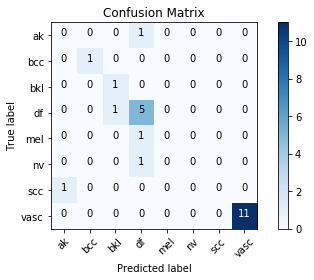

In [87]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['ak', 'bcc', 'bkl', 'df', 'mel','nv', 'scc', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Generate the Classification Report

In [0]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

In [89]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

          ak       0.00      0.00      0.00         1
         bcc       1.00      1.00      1.00         1
         bkl       0.50      1.00      0.67         1
          df       0.62      0.83      0.71         6
         mel       0.00      0.00      0.00         1
          nv       0.00      0.00      0.00         1
         scc       0.00      0.00      0.00         1
        vasc       1.00      1.00      1.00        11

    accuracy                           0.78        23
   macro avg       0.39      0.48      0.42        23
weighted avg       0.71      0.78      0.74        23



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**Recall** = Given a class, will the classifier be able to detect it?<br>
**Precision** = Given a class prediction from a classifier, how likely is it to be correct?<br>
**F1 Score** = The harmonic mean of the recall and precision. Essentially, it punishes extreme values.

In [0]:
# End of Model Building
### ===================================================================================== ###
# Convert the Model from Keras to Tensorflow.js

### test

In [0]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

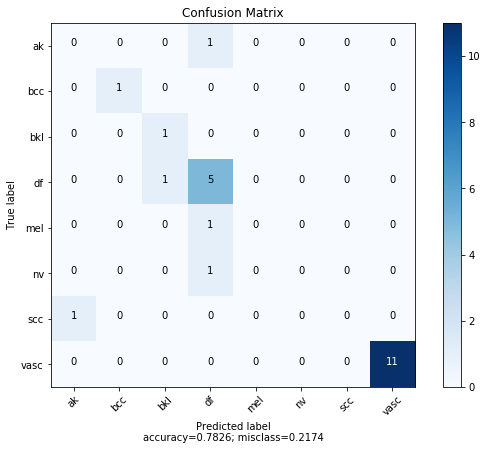

In [92]:
plot_confusion_matrix(cm           = cm ,
                      normalize    = False,
                      target_names = ['ak', 'bcc', 'bkl', 'df', 'mel', 'nv', 'scc', 'vasc'],
                      title        = "Confusion Matrix")

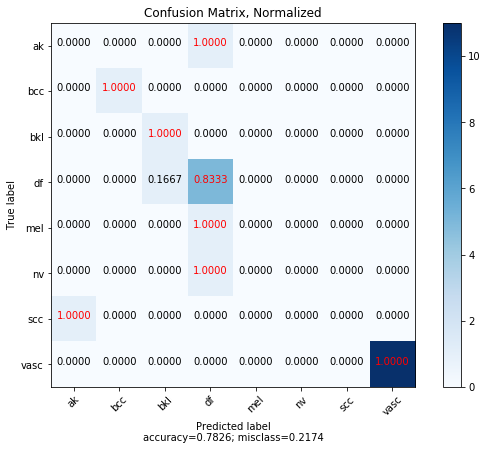

In [93]:
plot_confusion_matrix(cm           = cm, 
                      normalize    = True,
                      target_names = ['ak', 'bcc', 'bkl', 'df', 'mel', 'nv', 'scc', 'vasc'],
                      title        = "Confusion Matrix, Normalized")

In [0]:
!cp model.h5 -d 'drive/My Drive/vasc_df.h5'